In [4]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [6]:
from REVIVAL.util import calculate_chain_centroid, get_protein_structure

import numpy as np

In [24]:
def get_ligand_centroid(pdb_file, ligand_info):
    """
    Calculates the centroid of a given list of atoms specified by chain, residue, and atom names.

    Args:
        pdb_file (str): Path to the PDB file.
        ligand_info (list of tuples): List of atoms specified as (chain_id, residue_name, atom_name).

    Returns:
        tuple: Centroid coordinates as (x, y, z).
    """

    structure = get_protein_structure(pdb_file)

    atom_coords = []

    for chain_id, residue_name, atom_name in ligand_info:
        for model in structure:
            try:
                chain = model[chain_id]
                for residue in chain:
                    # Match residue name (flexible: partial match, case insensitive)
                    if residue_name.lower() in residue.resname.lower():
                        # Match atom name (flexible: ignore underscores and case differences)
                        for atom in residue:
                            if atom_name.replace("_", "").lower() == atom.name.replace("_", "").lower():
                                atom_coords.append(atom.coord)
            except KeyError:
                print(f"Chain {chain_id} not found in the structure.")
                continue

    if not atom_coords:
        raise ValueError("No matching atoms found in the structure.")

    # Calculate centroid
    return np.mean(atom_coords, axis=0)

In [34]:
def extract_active_site_by_radius(pdb_file, target_coord, target_chain="A", distance_threshold=10.0):
    """
    Extracts a list of amino acids in the specified chain whose centroids (side chain or CA for glycine)
    are within a given distance from a specified (x, y, z) coordinate.

    Args:
        pdb_file (str): Path to the PDB file.
        target_coord (tuple): Target (x, y, z) coordinate.
        target_chain (str): Chain ID to search within (default is "A").
        distance_threshold (float): Distance threshold in Ångströms.

    Returns:
        list: A list of tuples containing residue information
              (e.g., [("GLY", 12), ("ALA", 25)]).
    """
    structure = get_protein_structure(pdb_file)

    nearby_residues = []

    # Iterate through all residues in the specified chain
    for model in structure:
        chain = model[target_chain]  # Access the specified chain
        for residue in chain:
            # Exclude backbone atoms (N, CA, C, O) and calculate centroid of side chain atoms
            side_chain_atoms = [atom for atom in residue if atom.name not in {"N", "CA", "C", "O"}]

            if not side_chain_atoms:
                # Use the alpha carbon (CA) as the centroid for glycine
                if residue.resname == "GLY" and "CA" in residue:
                    ca_atom = residue["CA"]
                    centroid = np.array(ca_atom.coord)
                else:
                    # Skip residues with no side chains or CA
                    continue
            else:
                # Calculate the centroid of the side chain
                side_chain_coords = np.array([atom.coord for atom in side_chain_atoms])
                centroid = np.mean(side_chain_coords, axis=0)

            # Calculate distance between target coordinate and residue centroid
            distance = np.linalg.norm(centroid - target_coord)
            if distance <= distance_threshold:
                residue_info = (residue.resname, residue.id[1])
                nearby_residues.append(residue_info)

    return nearby_residues


In [31]:
from REVIVAL.global_param import LIB_INFO_DICT

In [22]:
LIB_INFO_DICT["PfTrpB-4bromo"]["4bromo-info"]

[('B', 'LIG', 'C1'),
 ('B', 'LIG', 'C2'),
 ('B', 'LIG', 'C3'),
 ('B', 'LIG', 'C4'),
 ('B', 'LIG', 'C5'),
 ('B', 'LIG', 'C6'),
 ('B', 'LIG', 'C7'),
 ('B', 'LIG', 'C8'),
 ('B', 'LIG', 'N1'),
 ('B', 'LIG', 'BR1')]

In [25]:
pdb_file = "/disk2/fli/REVIVAL2/zs/af3/struct_joint/PfTrpB-4bromo/i165a_i183a_y301v/seed-1_sample-0/model.cif"

In [26]:
get_ligand_centroid(pdb_file, LIB_INFO_DICT["PfTrpB-4bromo"]["4bromo-info"])

array([-1.9962   , -0.4137   , -6.8669004], dtype=float32)

In [35]:

extract_active_site_by_radius(pdb_file, get_ligand_centroid(pdb_file, LIB_INFO_DICT["PfTrpB-4bromo"]["4bromo-info"]), target_chain = "A", distance_threshold=12.0)

[('LYS', 82),
 ('ASN', 85),
 ('ALA', 103),
 ('GLU', 104),
 ('THR', 105),
 ('GLY', 106),
 ('ALA', 107),
 ('HIS', 110),
 ('ASP', 133),
 ('THR', 160),
 ('LEU', 161),
 ('LYS', 162),
 ('ASP', 163),
 ('ALA', 164),
 ('ALA', 165),
 ('ASP', 166),
 ('ALA', 168),
 ('LEU', 169),
 ('TYR', 181),
 ('ALA', 183),
 ('GLY', 184),
 ('SER', 185),
 ('VAL', 186),
 ('VAL', 187),
 ('GLY', 188),
 ('PRO', 189),
 ('TYR', 192),
 ('PRO', 193),
 ('VAL', 196),
 ('VAL', 226),
 ('GLY', 227),
 ('GLY', 228),
 ('GLY', 229),
 ('SER', 230),
 ('SER', 263),
 ('SER', 265),
 ('SER', 274),
 ('HIS', 275),
 ('GLY', 276),
 ('MET', 277),
 ('SER', 279),
 ('PHE', 281),
 ('ILE', 289),
 ('SER', 292),
 ('GLY', 298),
 ('LEU', 299),
 ('ASP', 300),
 ('VAL', 301),
 ('PRO', 302),
 ('GLY', 303),
 ('VAL', 304),
 ('GLY', 305),
 ('PRO', 306),
 ('HIS', 308)]

In [11]:
calculate_chain_centroid(pdb_file, chain_ids = ["B"])

array([-3.4316127 , -0.73019344, -1.117032  ], dtype=float32)

In [26]:
import os
import freesasa
from MDAnalysis import Universe
import MDAnalysis as mda
from rdkit import Chem
from rdkit.Chem import AllChem

def write_ligand_from_smiles(smiles, output_file):
    """
    Generate a PDB file for a ligand from a SMILES string.

    Args:
        smiles (str): SMILES string of the ligand.
        output_file (str): Path to save the generated PDB file.
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D coordinates
    Chem.MolToPDBFile(mol, output_file)

def calculate_sasa_from_inputs(pdb_file, active_site_residues, ligand_smiles=None):
    """
    Calculate SASA for active site residues and a ligand (from SMILES).

    Args:
        pdb_file (str): Path to the PDB file containing the protein.
        active_site_residues (list of tuple): List of active site residues as (resname, resid).
        ligand_smiles (str, optional): SMILES string for the ligand.

    Returns:
        dict: SASA values for the active site and the ligand (if provided).
    """
    # Load the PDB file
    u = Universe(pdb_file)
    
    # Select active site residues
    selection_query = " or ".join(
        [f"(resname {resname} and resid {resid} and segid A)" for resname, resid in active_site_residues]
    )
    active_site = u.select_atoms(selection_query)
    
    if len(active_site) == 0:
        raise ValueError("No atoms found for the specified active site residues.")

    # Write the active site to a temporary PDB file
    active_site_file = "active_site.pdb"
    with mda.Writer(active_site_file, multiframe=False) as writer:
        writer.write(active_site)

    # Calculate SASA for the active site
    active_site_structure = freesasa.Structure(active_site_file)
    active_site_sasa = freesasa.calc(active_site_structure).totalArea()

    results = {"active_site_sasa": active_site_sasa}

    # # If a ligand SMILES string is provided, generate the ligand PDB and calculate SASA
    # if ligand_smiles:
    #     ligand_file = "ligand.pdb"
    #     write_ligand_from_smiles(ligand_smiles, ligand_file)
    #     ligand_structure = freesasa.Structure(ligand_file)
    #     ligand_sasa = freesasa.calc(ligand_structure).totalArea()
    #     results["ligand_sasa"] = ligand_sasa

    #     # Clean up temporary ligand file
    #     os.remove(ligand_file)

    # Clean up temporary active site file
    os.remove(active_site_file)

    return results


In [5]:
from REVIVAL.zs.plip import get_plip_active_site_list

/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [24]:

# Example usage
file_path = "/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/report.xml"  # Replace with the path to your XML file
result = get_plip_active_site_list(file_path)
print(result)


[('LYS', 37), ('ALA', 23), ('MET', 12), ('LEU', 26), ('GLY', 37), ('GLY', 22), ('HIS', 11), ('GLN', 13), ('VAL', 11), ('ALA', 11), ('PRO', 30), ('GLU', 25), ('GLN', 20), ('GLN', 10), ('SER', 26), ('HIS', 27), ('GLY', 11), ('GLY', 7), ('HIS', 26), ('GLY', 18), ('ASN', 23), ('TYR', 12), ('GLY', 22), ('GLY', 30), ('LYS', 8), ('SER', 34), ('SER', 26), ('ASP', 16), ('ASN', 14), ('SER', 27), ('MET', 23), ('LEU', 28), ('GLY', 22), ('GLU', 34), ('LEU', 34), ('ALA', 8), ('ASN', 36), ('VAL', 19), ('ALA', 34), ('GLY', 18), ('VAL', 30), ('CYS', 22), ('MET', 27), ('SER', 18), ('GLU', 10), ('ASP', 37), ('TYR', 18), ('GLU', 7), ('GLY', 10), ('SER', 23), ('LEU', 37), ('ALA', 25), ('GLY', 29), ('VAL', 18), ('GLY', 30), ('THR', 10), ('HIS', 30), ('ASP', 13), ('GLY', 10), ('ASP', 30), ('VAL', 18), ('VAL', 22), ('ALA', 16), ('ALA', 16), ('ALA', 18), ('ARG', 37), ('LEU', 29), ('ALA', 26), ('ALA', 10), ('PHE', 28), ('LEU', 16), ('HIS', 8), ('PRO', 29), ('VAL', 30), ('SER', 37), ('LYS', 16), ('SER', 29)]


In [27]:
calculate_sasa_from_inputs(
    pdb_file="/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/I165A:I183A:Y301V_0.pdb",
    active_site_residues=get_plip_active_site_list(file_path), 
    ligand_smiles="C1=CC2=C(C=CN2)C(=C1)Br"
    )

{'active_site_sasa': 1255.8929758308375}

In [14]:

import os
import freesasa
from MDAnalysis import Universe
import MDAnalysis as mda


def calculate_sasa_from_pdb(pdb_file, active_site_residues=None, chains=None, specific_atoms=None):
    """
    Calculate SASA for active site residues, specified chains, or specific atoms.

    Args:
        pdb_file (str): Path to the PDB file containing the protein.
        active_site_residues (list of tuple): List of active site residues as (resname, resid).
        chains (list of str): List of chain identifiers to calculate SASA (e.g., ["B", "C"]).
        specific_atoms (list of tuple): List of specific atoms as (chain, residue, atom).

    Returns:
        float: SASA value for the specified selection.
    """
    # Ensure only one selection method is specified
    if sum(x is not None for x in [active_site_residues, chains, specific_atoms]) != 1:
        raise ValueError("Specify only one of active_site_residues, chains, or specific_atoms.")

    # Load PDB file
    u = Universe(pdb_file)

    # Build selection query
    if active_site_residues:
        selection_query = " or ".join(
            [f"(resname {resname} and resid {resid} and segid A)" for resname, resid in active_site_residues]
        )
    elif chains:
        selection_query = " or ".join([f"segid {chain}" for chain in chains])
    elif specific_atoms:
        selection_query = " or ".join(
            [f"(segid {chain} and resname {resname} and name {atom})" for chain, resname, atom in specific_atoms]
        )

    # Select atoms and validate
    selected_atoms = u.select_atoms(selection_query)
    if len(selected_atoms) == 0:
        raise ValueError("No atoms found for the specified selection.")

    # Write selected atoms to a temporary PDB file
    temp_file = "temp_selection.pdb"
    with mda.Writer(temp_file, multiframe=False) as writer:
        writer.write(selected_atoms)

    # Calculate SASA
    structure = freesasa.Structure(temp_file)
    sasa = freesasa.calc(structure).totalArea()

    # Clean up
    os.remove(temp_file)

    return sasa

In [15]:


calculate_sasa_from_pdb(
    pdb_file="/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/I165A:I183A:Y301V_0.pdb",
    active_site_residues=get_plip_active_site_list("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/report.xml" ),
    # chains=["B"]
    )

1255.8929758308375

In [ ]:
calculate_sasa_from_pdb(
    pdb_file="/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/I165A:I183A:Y301V_0.pdb",
    # active_site_residues=get_plip_active_site_list("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/report.xml" ),
    chains=["B"]
    )

FreeSASA: warning: atom 'LIG BR1 ' unknown, guessing element is 'BR', and radius 1.830 A
FreeSASA: warning: atom 'LIG  C1 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C2 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C3 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C4 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C5 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  N1 ' unknown, guessing element is ' N', and radius 1.550 A
FreeSASA: warning: atom 'LIG  C6 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C7 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C8 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C9 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: at

849.5631732753901

In [17]:
calculate_sasa_from_pdb(
    pdb_file="/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/I165A:I183A:Y301V_0.pdb",
    # active_site_residues=get_plip_active_site_list("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/PfTrpB-4bromo/I165A:I183A:Y301V_0/report.xml" ),
    # chains=["B"]
    specific_atoms=[
                ("B", "LIG", "C1"),
                ("B", "LIG", "C2"),
                ("B", "LIG", "C3"),
                ("B", "LIG", "C4"),
                ("B", "LIG", "C5"),
                ("B", "LIG", "C6"),
                ("B", "LIG", "C7"),
                ("B", "LIG", "C8"),
                ("B", "LIG", "N1"),
                ("B", "LIG", "BR1"),
            ]
    )

FreeSASA: warning: atom 'LIG BR1 ' unknown, guessing element is 'BR', and radius 1.830 A
FreeSASA: warning: atom 'LIG  C1 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C2 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C3 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C4 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C5 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  N1 ' unknown, guessing element is ' N', and radius 1.550 A
FreeSASA: warning: atom 'LIG  C6 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C7 ' unknown, guessing element is ' C', and radius 1.700 A
FreeSASA: warning: atom 'LIG  C8 ' unknown, guessing element is ' C', and radius 1.700 A


291.37273927053644

In [29]:
write_ligand_from_smiles("C1=CC2=C(C=CN2)C(=C1)Br", "test.pdb")

In [33]:
def add_chain_to_pdb(pdb_file, output_file, chain_id="A"):
    with open(pdb_file, "r") as f, open(output_file, "w") as out:
        for line in f:
            if line.startswith("HETATM"):
                out.write(line[:21] + chain_id + line[22:])
            else:
                out.write(line)

# Example usage
add_chain_to_pdb("test.pdb", "test_fixed.pdb", chain_id="A")


In [38]:
freesasa.Structure("/disk2/fli/REVIVAL2/test_fixed.pdb")

FreeSASA:lib/src/structure.c:693: error: input had no valid ATOM or HETATM lines
FreeSASA:lib/src/structure.c:700: error: 


Exception: Error reading '/disk2/fli/REVIVAL2/test_fixed.pdb'.

In [40]:
from rdkit.Chem import rdFreeSASA

def compute_sasa(mol):
    """Compute Solvent Accessible Surface Area.
    """
    mol = Chem.AddHs(mol)

    # Get Van der Waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]

    # Compute solvent accessible surface area
    sa = rdFreeSASA.CalcSASA(mol, radii, confIdx=-1)
    
    return sa


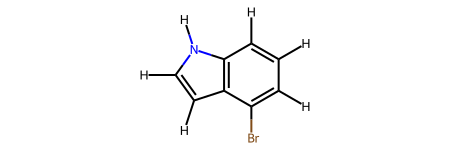

In [46]:
mol = Chem.MolFromSmiles("C1=CC2=C(C=CN2)C(=C1)Br")
mol = Chem.AddHs(mol)
mol

In [48]:
ptable = Chem.GetPeriodicTable()

In [49]:
radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]


In [50]:
radii

[1.7,
 1.7,
 1.7,
 1.7,
 1.7,
 1.7,
 1.6,
 1.7,
 1.7,
 1.9,
 1.2,
 1.2,
 1.2,
 1.2,
 1.2,
 1.2]

In [58]:
AllChem.EmbedMolecule(mol, AllChem.ETKDG()) 

0

In [59]:
rdFreeSASA.CalcSASA(mol, radii, confIdx=-1)

317.5083758487219

In [25]:
from rdkit.Chem import Descriptors, MolSurf, Descriptors3D

In [56]:
Descriptors.MolLogP(mol)

2.9304000000000006

In [57]:
Chem.rdMolDescriptors.CalcTPSA(mol)

15.79

In [18]:
from REVIVAL.global_param import LIB_INFO_DICT

In [19]:
LIB_INFO_DICT["PfTrpB-4bromo"]

{'enzyme': 'PfTrpB',
 'substrate': '4bromo',
 'substrate-smiles': 'C1=CC2=C(C=CN2)C(=C1)Br',
 'cofactor': ['PLP-dependent_aminoacrylate', 'Na+'],
 'cofactor-smiles': ['[O-]C1=C(/C=[N+]([H])/C(C([O-])=O)=C)C(CP([O-])([O-])=O)=CN=C1C',
  '[Na+]'],
 'inactivated-cofactor': ['PLP', 'Na+'],
 'inactivated-cofactor-smiles': ['O=Cc1c(O)c(C)ncc1COP(O)(O)=O', '[Na+]'],
 'transiminated-cofactor': ['aldimine', 'Na+'],
 'transiminated-cofactor-smiles': ['[O-]C1=C(/C=[N+]([H])/[C@](CO)([H])C([O-])=O)C(CP([O-])([O-])=O)=CN=C1C',
  '[Na+]'],
 'intermediate-smiles': ['CC1=C([O-])C(\\C=[NH+]\\[C@@H](CC2=CNC3=CC=CC(Br)=C23)C([O-])=O)=C(COP([O-])([O-])=O)C=N1',
  '[Na+]'],
 '4bromo-info': [('B', 'LIG', 'C1'),
  ('B', 'LIG', 'C2'),
  ('B', 'LIG', 'C3'),
  ('B', 'LIG', 'C4'),
  ('B', 'LIG', 'C5'),
  ('B', 'LIG', 'C6'),
  ('B', 'LIG', 'C7'),
  ('B', 'LIG', 'C8'),
  ('B', 'LIG', 'N1'),
  ('B', 'LIG', 'BR1')],
 'substrate-addH_chai': [('B', 'LIG', 'N1')],
 'cofactor-addH_chai_joint': [('B', 'LIG', 'N2'),
  ('B

In [21]:
LIB_INFO_DICT["PfTrpB-4bromo"]["substrate-smiles"] + "." + ".".join(LIB_INFO_DICT["PfTrpB-4bromo"]["cofactor-smiles"])

'C1=CC2=C(C=CN2)C(=C1)Br.[O-]C1=C(/C=[N+]([H])/C(C([O-])=O)=C)C(CP([O-])([O-])=O)=CN=C1C.[Na+]'

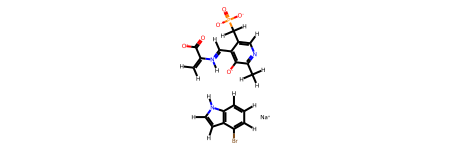

In [23]:

from rdkit import Chem

mol = Chem.MolFromSmiles(LIB_INFO_DICT["PfTrpB-4bromo"]["substrate-smiles"] + "." + ".".join(LIB_INFO_DICT["PfTrpB-4bromo"]["cofactor-smiles"]))
mol = Chem.AddHs(mol)
mol

In [26]:
Descriptors.MolLogP(mol)

-4.4251799999999974

In [27]:
Chem.rdMolDescriptors.CalcTPSA(mol)

169.02999999999997

In [28]:
MolSurf.TPSA(mol)

169.02999999999997

In [29]:
Descriptors.TPSA(mol)

169.02999999999997

In [33]:
MolSurf.LabuteASA(mol)

230.67815957353233